In [1]:
%matplotlib inline

In [24]:
from glob import glob
from scipy import constants

In [3]:
npy_files = glob('*num_0_1_2_atten_41.npy')
df = pd.concat([pd.DataFrame.from_records(np.load(npy_file)) for npy_file in npy_files], ignore_index=True)
df.shape

(51, 74)

# Data cuts

In [4]:
# There's still one bad fit in here
df = df[df.res_Q_i != df.res_Q_i.max()]
df.shape

(50, 74)

In [5]:
# Two of these show switching behavior
df = df[np.logical_not((df.magnet_array_height_mm==162) & (df.number!=2))]
df.shape

(48, 74)

In [6]:
Qi_scale = 1e-5
Qi_mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=Qi_scale * 0,
                                                              vmax=Qi_scale * df.res_Q_i.max()),
                                    cmap=plt.cm.coolwarm)
Qi_mappable.set_array(np.array(df.res_Q_i))

B_mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=df.field_uT.min(),
                                                             vmax=df.field_uT.max()),
                                   cmap=plt.cm.coolwarm)
B_mappable.set_array(np.unique(df.field_uT))

# Temperature

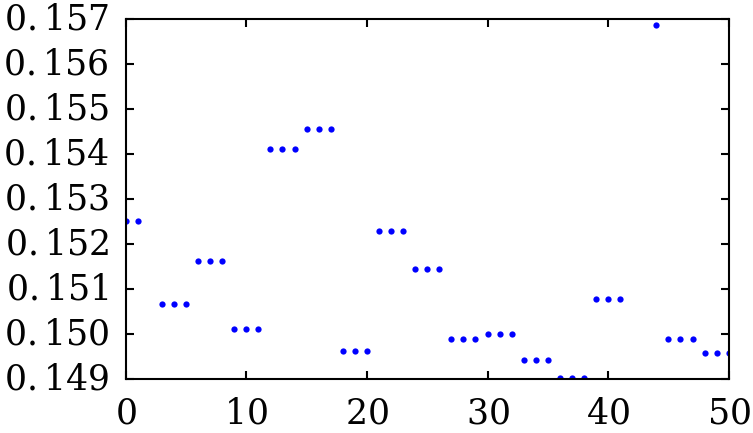

In [20]:
fig, ax = plt.subplots()
ax.plot(df.temperature_package, '.')

In [22]:
df[df.temperature_package == df.temperature_package.max()].magnet_array_height_mm

44    162
Name: magnet_array_height_mm, dtype: object

# Flux density

In [26]:
Phi_0 = constants.physical_constants['mag. flux quantum'][0]
w = 12e-6
B_th = Phi_0 * w**-2
print("B_th is approximately {:.1f} uT".format(1e6 * B_th))

B_th is approximately 14.4 uT


# $1 / Q_i$ vs. $B$

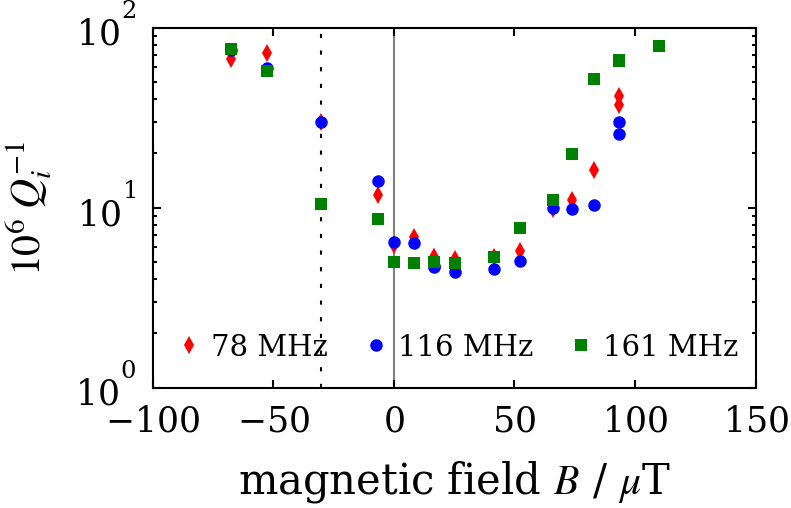

In [19]:
numbers = [0, 1, 2]
colors = ['red', 'blue', 'green']
markers = ['d', 'o', 's']
markersize = 3
alpha = 1

fig, ax = plt.subplots()
ax.set_xlabel('magnetic field $B$ / $\mu$T')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
ax.set_yscale('log')
B_shield = df[df.shield].field_uT.iloc[0]
B_ambient = df[df.ambient].field_uT.iloc[0]
ax.axvline(B_shield, linestyle='-', color='gray', alpha=1)
ax.axvline(B_ambient, linestyle=':', color='black', alpha=1)

for number in numbers:
    dfn = df[df.number == number]
    ax.plot(dfn.field_uT,
            1e6 / dfn.res_Q_i,
            marker=markers[number], color=colors[number],
            markersize=markersize, linestyle='none', alpha=alpha,
            label='{:.0f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))

ax.legend(loc='lower center', ncol=len(numbers), fontsize=7, numpoints=1);

fig.savefig('iQi_vs_B.pdf', bbox_inches='tight')

(0, 90)

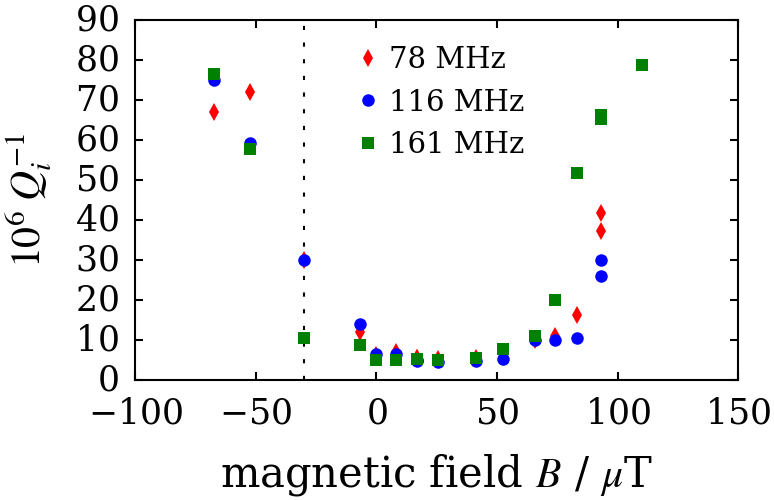

In [14]:
numbers = [0, 1, 2]
colors = ['red', 'blue', 'green']
markers = ['d', 'o', 's']
markersize = 3
alpha = 1

fig, ax = plt.subplots()
ax.set_xlabel('magnetic field $B$ / $\mu$T')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
B_shield = df[df.shield].field_uT.iloc[0]
B_ambient = df[df.ambient].field_uT.iloc[0]
#ax.axvline(B_shield, linestyle='-', color='gray', alpha=1)
ax.axvline(B_ambient, linestyle=':', color='black', alpha=1)

for number in numbers:
    dfn = df[df.number == number]
    """
    ax.plot(dfn[dfn.shield].field_uT,
            1e6 / dfn[dfn.shield].res_Q_i,
            marker=shield_marker, markersize=markersize, linestyle='none', color=colors[number], alpha=alpha)
    ax.plot(dfn[dfn.ambient].iloc[0].ambient_field_uT,
            1e6 / dfn[dfn.ambient].iloc[0].res_Q_i,
            marker=ambient_marker, markersize=markersize, linestyle='none', color=colors[number], alpha=alpha)
    array_mask = np.logical_not(np.logical_or(dfn.shield, dfn.ambient))
    """
    ax.plot(dfn.field_uT,
            1e6 / dfn.res_Q_i,
            marker=markers[number], color=colors[number],
            markersize=markersize, linestyle='none', alpha=alpha,
            label='{:.0f} MHz'.format(1e-6 * dfn.iloc[0].res_f_0))

ax.legend(loc='upper center', ncol=1, fontsize=7, numpoints=1);
ax.set_ylim(0, 90)
#fig.savefig('iQi_vs_B_linear.pdf', bbox_inches='tight')

# $S_{xx}$ with $Q_i$ colorbar

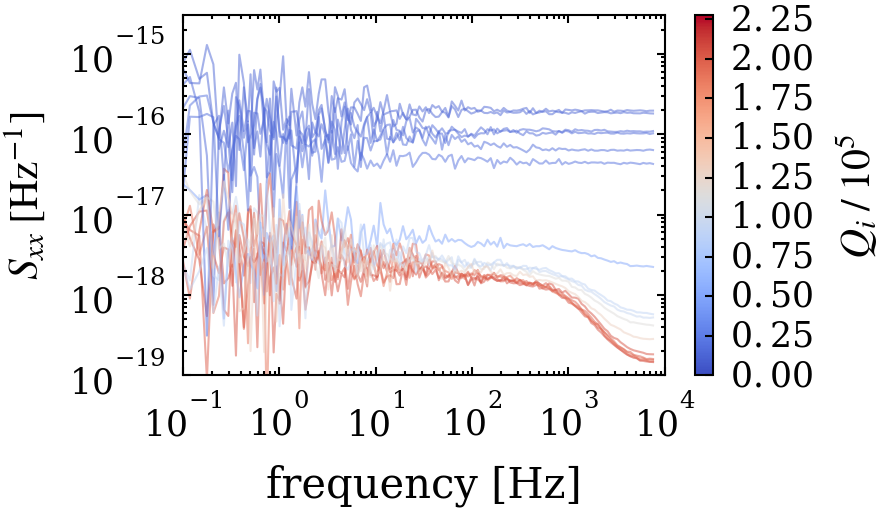

In [8]:
number = 2

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel(r'$S_{xx} \; [\mathrm{Hz}^{-1}]$')

for n, row in df[df.number==number].iterrows():
    ax.plot(row.S_frequency_masked_binned,
            row.S_xx_masked_binned,
            color=Qi_mappable.to_rgba(Qi_scale * row.res_Q_i),
            alpha=0.5)

fig.colorbar(Qi_mappable, label='$Q_i \; / \; 10^5$')

ax.set_xlim(1e-1, 1e4)
ax.set_ylim(1e-19, 3e-15)

fig.savefig('noise_Qi.pdf', bbox_inches='tight')

# $S_{xx}$ with $B$ colorbar

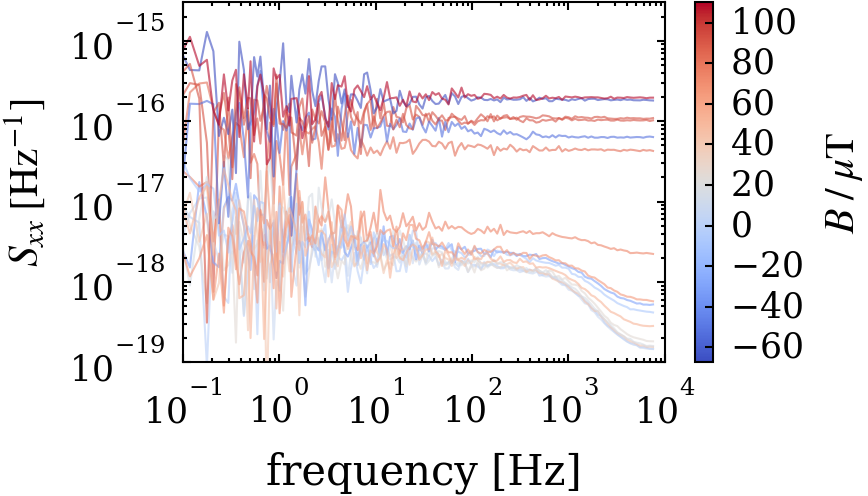

In [9]:
number = 2

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel(r'$S_{xx} \; [\mathrm{Hz}^{-1}]$')

for n, row in df[df.number==number].iterrows():
    ax.plot(row.S_frequency_masked_binned,
            row.S_xx_masked_binned,
            color=B_mappable.to_rgba(row.field_uT),
            alpha=0.6)

fig.colorbar(B_mappable, label='$B \; / \; \mu \mathrm{T}$')

ax.set_xlim(1e-1, 1e4)
ax.set_ylim(1e-19, 3e-15)

fig.savefig('noise_B.pdf', bbox_inches='tight')

# $S_{yy}$ with $Q_i$ colorbar

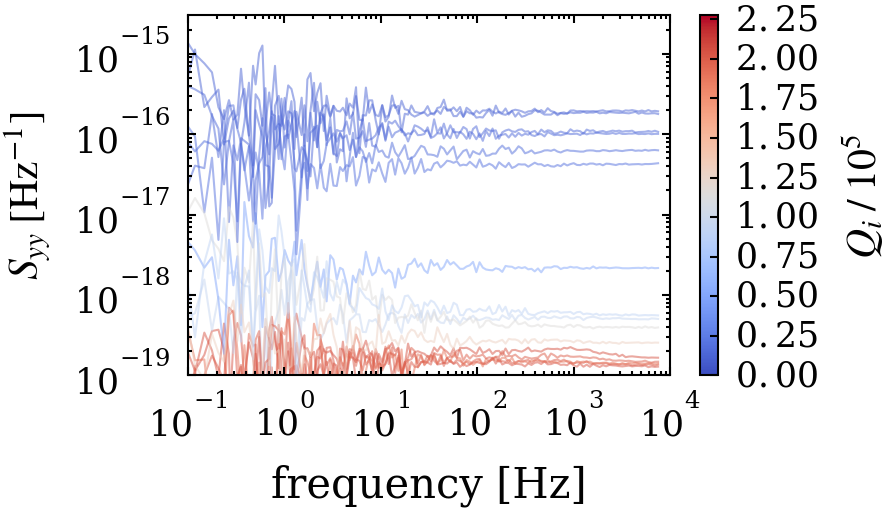

In [15]:
number = 2

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel(r'$S_{yy} \; [\mathrm{Hz}^{-1}]$')

for n, row in df[df.number==number].iterrows():
    ax.plot(row.S_frequency_masked_binned,
            row.S_yy_masked_binned,
            color=Qi_mappable.to_rgba(Qi_scale * row.res_Q_i),
            alpha=0.5)

fig.colorbar(Qi_mappable, label='$Q_i \; / \; 10^5$')

ax.set_xlim(1e-1, 1e4)
ax.set_ylim(1e-19, 3e-15);